In [2]:
# imports
#from GDapp.models import add_analyzed_image, add_gold_particle_coordinates, add_histogram_image
import os
from skimage import io  # library for python to help access pictures
import numpy as np  # help do math in python
import matplotlib.pyplot as plt
import random
import imageio
from PIL import Image
import sys

from skimage.util.shape import view_as_windows, view_as_blocks
import imutils

import os
import cv2

import glob
import shutil
import re
import pandas as pd
import pathlib

import time
import errno
import os
import stat
import shutil
from django.conf import settings
# from sklearn.cluster import Kmeans

In [3]:
def get_artifact_status(model):
    # gets rid of the constant artifact in the up left corner
    if model == '87kGoldDigger':
        artifact = True
    else:
        artifact = False
    return artifact

In [4]:
def clear_out_old_files(model):
    shutil.rmtree('media/Output', ignore_errors=True)
    os.makedirs('media/Output')

    shutil.rmtree('media/Output_Appended', ignore_errors=True)
    os.makedirs('media/Output_Appended')

    shutil.rmtree('media/Output_Appended/test', ignore_errors=True)
    os.makedirs('media/Output_Appended/test')

    shutil.rmtree(
        'media/PIX2PIX/results/{0}/test_latest/images'.format(model), ignore_errors=True)
    os.makedirs('media/PIX2PIX/results/{0}/test_latest/images'.format(model))

    shutil.rmtree('media/Output_ToStitch', ignore_errors=True)
    os.makedirs('media/Output_ToStitch')

    shutil.rmtree('media/Output_Final', ignore_errors=True)
    os.makedirs('media/Output_Final')

    try:
        os.remove('media/GD_Output.zip')
    except:
        pass

In [5]:
# look in INPUT folder, crop photo and save crop to OUTPUT folder
# Cut up in order, append white images

def load_data_make_jpeg(image, mask):
    file_list = pathlib.Path('media/Input', image)
    print(file_list)
    for entry in [file_list]:

        img_size = (256, 256, 3)
        img_new = io.imread(entry)
        # img_new = (img_new/256).astype('uint8')
        shape = img_new.shape
        height = shape[0] // 256
        height256 = height * 256
        width = shape[1] // 256
        width256 = width * 256

        img_new = img_new[:height256, :width256, :3]
        img_mask = None
        if mask is not None:
            mask_path = pathlib.Path('media/Mask', mask)
            img_mask = io.imread(mask_path)
            img_mask = img_mask[:height256, :width256, :3]
        img_new_w = view_as_blocks(img_new, img_size)
        img_new_w = np.uint8(img_new_w)
        imageio.imwrite('media/Output_Final/' +
                        'CroppedVersion' + '.png', img_new)
        r = 0
        for i in range(img_new_w.shape[0]):
            for j in range(img_new_w.shape[1]):
                A = np.zeros((img_size[0], img_size[1], 3))
                A[:, :, :] = img_new_w[i, j, :, :]
                # A = np.uint8(A)
                imageio.imwrite('media/Output/' + str(r) + '.png', A)
                r += 1
    return file_list, width, height, img_mask

In [6]:
def combine_white(white, folderA):
    print(os.getcwd())
    os.chdir(folderA)
    for file in os.listdir('.'):
        imA = io.imread(file)
        newimage = np.concatenate((imA, white), axis=1)
        imageio.imwrite('../Output_Appended/test/' + file, newimage)

    os.chdir('../../')
    print(os.getcwd())


In [7]:
# Save to OUTPUT folder
def save_to_output_folder(file_list, model):
    for entry in file_list:
        split_name = entry.split('/')
        print(split_name)
        dirA = 'media/PIX2PIX/results/{0}/test_latest/images/'.format(model)
        pathA = os.path.join(dirA, split_name[-1])
        dirB = 'media/Output_ToStitch/'
        pathB = os.path.join(dirB, split_name[-1])
        shutil.move(pathA, pathB)

In [8]:
# STICH TOGETHER


def stitch_row(n, master, folderstart, artifact, widthdiv256):
    image1 = imageio.imread(folderstart + master[n])
    if (artifact):
        image1[0:35, 220:256, :] = 0
    file1 = np.array(image1)

    image2 = imageio.imread(folderstart + master[n + 1])
    if (artifact):
        image2[0:35, 220:256, :] = 0
    file2 = np.array(image2)

    full_row = np.concatenate((file1, file2), axis=1)
    for i in range(n + 2, n + widthdiv256):
        image3 = imageio.imread(folderstart + master[i])
        if (artifact):
            image3[0:35, 220:256, :] = 0
        file_next = np.array(image3)
        full_row = np.concatenate((full_row, file_next), axis=1)
    return full_row

In [9]:
def stitch_image(folderstart, widthdiv256, heighttimeswidth, artifact):
    files = os.listdir(folderstart)
    file_list = []
    for file in files:
        split_name = re.split('\D', file)
        file_list.append(split_name[0])

    file_list.sort(key=float)
    master = []
    for file in file_list:
        name = file + '_fake_B.png'
        master.append(name)

    picture = stitch_row(0, master, folderstart, artifact, widthdiv256)
    for n in range(widthdiv256, heighttimeswidth, widthdiv256):
        next_row = stitch_row(n, master, folderstart, artifact, widthdiv256)
        picture = np.concatenate((picture, next_row), axis=0)
    return picture, file_list

In [10]:
def count_green_dots():
    # From Diego:
    # 1. Finds green square and then the center of that (x,y)
    # 2. Then I perform a flood fill on that (x,y) on the original image
    # 3. So it fills out the entire dark particle
    # 4. Then I find the contour of that mask and the xy of that new circle
    # 5. I do this so inconsistencies in the green mask dont affect the area of the gold particle
    # Basically it just uses the green masks to find a seed point to start flood filling. This makes sure that the mask is the exact size of the gold particle
    img = cv2.imread('media/Output_Final/OutputStitched.png')
    img_original = cv2.imread('media/Output_Final/CroppedVersion.png')
    img_original = np.uint8(img_original)

    h, w = img_original.shape[:2]
    flood_mask = np.zeros((h + 2, w + 2), dtype=np.uint8)

    lower_green = np.array([0, 245, 0])
    upper_green = np.array([40, 255, 40])

    mask = cv2.inRange(img, lower_green, upper_green)
    kernel = np.ones((5, 5), np.uint8)
    e = cv2.erode(mask, kernel, iterations=1)
    d = cv2.dilate(e, kernel, iterations=1)

    cnts = cv2.findContours(d, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    seedlistx = []
    seedlisty = []
    for c in cnts:
        M = cv2.moments(c)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            M["m00"] = 1
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])

        if (cX != 0 or cY != 0):
            if img_original[cY, cX, 0] < 120:
                seedlistx.append(cX)
                seedlisty.append(cY)

    listlen = len(seedlistx)
    floodflags = 4
    floodflags |= cv2.FLOODFILL_MASK_ONLY
    floodflags |= (255 << 8)
    for i in range(listlen):
        num, im, mask, rect = cv2.floodFill(img_original, flood_mask, (seedlistx[i], seedlisty[i]), 1, (4,) * 3, (4,) * 3,
                                            floodflags)

    print(np.mean(img_original))
    # cv2.imshow("Image", flood_mask)
    # cv2.waitKey(0)

    flood_mask = flood_mask[:h, :w]
    cnts = cv2.findContours(
        flood_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    return cnts

In [11]:
def check_if_coordinate_is_in_mask(x,y,mask):
    print(x,y)
    #print(mask.shape)
    #print(mask[x,y])
    #print(mask[x,y].shape)
    
    
    if mask is None:
        return True
    #elif mask[x,y] != np.array((255,255,255)):
    #    return True
    #else:
    #    return False
    elif np.array_equal(mask[x,y], np.array((255,255,255))):
        return False
    else:
        return True

In [46]:
def get_contour_centers_and_group(particle_group_count, cnts, img_mask):
    # group using k means
    # report size distributions
    # show relative size histograms and cutoffs
    results6 = pd.DataFrame(columns=['X', 'Y'])
    results12 = pd.DataFrame(columns=['X', 'Y'])
    results18 = pd.DataFrame(columns=['X', 'Y'])
    all_coordinates = pd.DataFrame(columns=['X','Y','Area'])
    for c in cnts:
        #    compute the center of the contour, then detect the name of the
        # shape using only the contour
        M = cv2.moments(c)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            M["m00"] = 1
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])

        if not (cX == 0 and cY == 0):
            all_coordinates = all_coordinates.append({'X': cX, 'Y': cY,'Area':cv2.contourArea(c)}, ignore_index=True)
            if check_if_coordinate_is_in_mask(cY, cX, img_mask):
                if particle_group_count == 1:
                    if cv2.contourArea(c) < 1500:
                        results6 = results6.append(
                        {'X': cX, 'Y': cY}, ignore_index=True)
                if particle_group_count == 2:
                    if cv2.contourArea(c) < 100:
                        results6 = results6.append(
                           {'X': cX, 'Y': cY}, ignore_index=True)
                    elif cv2.contourArea(c) >= 100 and cv2.contourArea(c) < 1500:
                        results12 = results12.append(
                           {'X': cX, 'Y': cY}, ignore_index=True)
                if particle_group_count == 3:
                    if cv2.contourArea(c) < 75:
                        results6 = results6.append(
                           {'X': cX, 'Y': cY}, ignore_index=True)
                    elif cv2.contourArea(c) >= 75 and cv2.contourArea(c) < 350:
                        results12 = results12.append(
                           {'X': cX, 'Y': cY}, ignore_index=True)
                    elif cv2.contourArea(c) >= 350 and cv2.contourArea(c) < 1500:
                        results18 = results18.append(
                           {'X': cX, 'Y': cY}, ignore_index=True)


    return all_coordinates, results6, results12, results18

In [13]:
def clear_out_input_dirs():
    shutil.rmtree('media/Input')
    os.mkdir('media/Input')


In [14]:
def update_progress(progress_recorder, step, total_steps, message):
    if progress_recorder is not None:
        progress_recorder.set_progress(step, total_steps, message)

In [15]:
def save_preview_figure(coordinates, front_end_updater):
    img = cv2.imread('media/Output_Final/OutputStitched.png')
    img2 = img[:,:,::-1]
    plt.figure(1)
    plt.imshow(img2)
    plt.scatter(coordinates.X.values,coordinates.Y.values, facecolors='none',edgecolors='r')
    plt.gca().set_axis_off()
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    preview_file_path = 'media/Output_Final/preview.png'
    if os.path.exists(preview_file_path):
        os.remove(preview_file_path)
    plt.savefig(preview_file_path, bbox_inches = 'tight',
        pad_inches = 0)
    add_analyzed_image(front_end_updater.pk, preview_file_path)

In [16]:
def save_histogram(coordinates, front_end_updater):
    plt.figure(2)
    plt.hist(coordinates.Area.values, bins=100)
    plt.title('Particle Area Histogram')
    plt.xlabel('Size (px)')
    plt.ylabel('Count')
    hist_path = 'media/Output_Final/preview_histogram.png'
    if os.path.exists(hist_path):
        os.remove(hist_path)
    plt.savefig(hist_path, bbox_inches='tight')
    add_histogram_image(front_end_updater.pk, hist_path)

In [17]:
def save_all_results(coordinates, front_end_updater):
    sub_path = 'results'
    results_path = os.path.join(settings.MEDIA_ROOT, sub_path)
    if not os.path.isdir(results_path):
        os.makedirs(results_path)
    timestr = time.strftime("%Y%m%d%H%M%S")
    coordinates_path_relative = os.path.join(sub_path, 'coordinates' + timestr + '.csv')
    coordinates_path_absolute = os.path.join(settings.MEDIA_ROOT, coordinates_path_relative)
    coordinates.to_csv(coordinates_path_absolute, index=None,
                                 header=True)
    add_gold_particle_coordinates(front_end_updater.pk, coordinates_path_absolute)
    save_preview_figure(coordinates,front_end_updater)
    save_histogram(coordinates, front_end_updater)

In [18]:
def run_gold_digger(model, input_image_list, particle_group_count, mask=None, front_end_updater=None):
    print(f'Running with {model}')
    # progress_setter = ProgressBarWrapper(front_end_updater, 20)
    #front_end_updater.update(1, "starting")
    artifact = get_artifact_status(model)
    clear_out_old_files(model)
    #front_end_updater.update(2, "loading and cutting up image")
    file_list, width, height, img_mask = load_data_make_jpeg(
        input_image_list, mask)
    #front_end_updater.update(4, "combining with white background")
    white = io.imread('media/White/white.png')
    combine_white(white, 'media/Output')
    #front_end_updater.update(5, "running PIX2PIX...")
    os.system(
        'python3 media/PIX2PIX/test.py --dataroot media/Output_Appended/ --name {0} --model pix2pix --direction AtoB --num_test 1000000 --checkpoints_dir media/PIX2PIX/checkpoints/ --results_dir media/PIX2PIX/results/'.format(
            model))
    print("RAN PIX2PIX")
   # front_end_updater.update(6, "Finished. stitching files together...")
    # Take only the Fake_B photos and stich together
    file_list = glob.glob(
        'media/PIX2PIX/results/{0}/test_latest/images/*_fake_B.png'.format(model))
    print("---BEFORE STITCH---")
    widthdiv256 = width
    heighttimeswidth = width * height
    folderstart = 'media/Output_ToStitch/'
    save_to_output_folder(file_list, model)
    picture, file_list = stitch_image(
        folderstart, widthdiv256, heighttimeswidth, artifact)
    imageio.imwrite('media/Output_Final/OutputStitched.png', picture)
    #front_end_updater.update(7, "Identifying green dots")
    cnts = count_green_dots()
    print("THIS IS WHERE IT WOULD SHOW THE IMAGE")
    all_coordinates, results6, results12, results18 = get_contour_centers_and_group(particle_group_count,
                                                                   cnts, img_mask)
    save_all_results(all_coordinates, front_end_updater)

    clear_out_input_dirs()
    print("SUCCESS!!")
    #front_end_updater.update(8, "Saving files")
    shutil.make_archive('media/GD_Output', 'zip', 'media/Output_Final')
    print('CREATED ZIP FILE')
    #front_end_updater.update(9, "All done")
    #front_end_updater.analysis_done()

In [19]:
model='87kGoldDigger'
input_image_list = 'test_image.tif'
mask = 'test_mask.tif'

In [20]:
artifact = get_artifact_status(model)
print(artifact)

True


In [21]:
#can do this manually
clear_out_old_files(model)
print("done")

done


In [22]:
file_list, width, height, img_mask = load_data_make_jpeg(input_image_list, mask)
print(file_list)
print(width)
print(height)
print(img_mask)

media/Input/test_image.tif


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 190.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 195.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [7.0, 169.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [50.0, 190.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [5.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 219.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 249.0]. Convert image to uint8 prior to saving to suppress this warning.

Lossy conversion from float64 to uint8. Range [41.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [43.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [54.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [27.0, 178.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [37.0, 201.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 251.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [36.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 230.0]. Convert image to uint8 prior to saving to suppress this war

Lossy conversion from float64 to uint8. Range [90.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [38.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [24.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warnin

Lossy conversion from float64 to uint8. Range [24.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [22.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 244.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [18.0, 221.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [1.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [83.0, 212.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [71.0, 238.0]. Convert image to uint8 prior to saving to suppress this warn

Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 239.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 186.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [25.0, 155.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [27.0, 168.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning

Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 232.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 221.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [6.0, 253.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [8.0, 253.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [39.0, 253.0]. Convert image to uint8 prior to saving to suppress this warning.

Lossy conversion from float64 to uint8. Range [37.0, 243.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [19.0, 210.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [28.0, 208.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [34.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [24.0, 189.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [61.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [58.0, 193.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this wa

Lossy conversion from float64 to uint8. Range [61.0, 253.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [31.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [55.0, 233.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [39.0, 250.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [46.0, 237.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [24.0, 236.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [20.0, 156.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 183.0]. Convert image to uint8 prior to saving to suppress this wa

Lossy conversion from float64 to uint8. Range [23.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [14.0, 217.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [29.0, 244.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [62.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [23.0, 233.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 205.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 186.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [47.0, 167.0]. Convert image to uint8 prior to saving to suppress this war

Lossy conversion from float64 to uint8. Range [6.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 193.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [19.0, 228.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [15.0, 233.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [4.0, 201.0]. Convert image to uint8 prior to saving to suppress this warning

media/Input/test_image.tif
25
28
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


In [23]:
white = io.imread('media/White/white.png')

In [24]:
combine_white(white, 'media/Output')

/home/MPFI.ORG/stuarte/Desktop/GoldDigger
/home/MPFI.ORG/stuarte/Desktop/GoldDigger


In [25]:
os.system(
        'python3 media/PIX2PIX/test.py --dataroot media/Output_Appended/ --name {0} --model pix2pix --direction AtoB --num_test 1000000 --checkpoints_dir media/PIX2PIX/checkpoints/ --results_dir media/PIX2PIX/results/'.format(
            model))
print("RAN PIX2PIX")

RAN PIX2PIX


In [26]:
# Take only the Fake_B photos and stich together
file_list = glob.glob('media/PIX2PIX/results/{0}/test_latest/images/*_fake_B.png'.format(model))
print("---BEFORE STITCH---")

---BEFORE STITCH---


In [27]:
widthdiv256 = width
heighttimeswidth = width * height
folderstart = 'media/Output_ToStitch/'

In [28]:
save_to_output_folder(file_list, model)
print("done")

['media', 'PIX2PIX', 'results', '87kGoldDigger', 'test_latest', 'images', '234_fake_B.png']
['media', 'PIX2PIX', 'results', '87kGoldDigger', 'test_latest', 'images', '641_fake_B.png']
['media', 'PIX2PIX', 'results', '87kGoldDigger', 'test_latest', 'images', '410_fake_B.png']
['media', 'PIX2PIX', 'results', '87kGoldDigger', 'test_latest', 'images', '39_fake_B.png']
['media', 'PIX2PIX', 'results', '87kGoldDigger', 'test_latest', 'images', '536_fake_B.png']
['media', 'PIX2PIX', 'results', '87kGoldDigger', 'test_latest', 'images', '534_fake_B.png']
['media', 'PIX2PIX', 'results', '87kGoldDigger', 'test_latest', 'images', '452_fake_B.png']
['media', 'PIX2PIX', 'results', '87kGoldDigger', 'test_latest', 'images', '366_fake_B.png']
['media', 'PIX2PIX', 'results', '87kGoldDigger', 'test_latest', 'images', '230_fake_B.png']
['media', 'PIX2PIX', 'results', '87kGoldDigger', 'test_latest', 'images', '86_fake_B.png']
['media', 'PIX2PIX', 'results', '87kGoldDigger', 'test_latest', 'images', '296_fak

In [29]:
picture, file_list = stitch_image(folderstart, widthdiv256, heighttimeswidth, artifact)
imageio.imwrite('media/Output_Final/OutputStitched.png', picture)

In [30]:
cnts = count_green_dots()
print(cnts)

138.92458818708147
[array([[[1284, 7072]]], dtype=int32), array([[[4824, 6957]],

       [[4823, 6958]],

       [[4822, 6958]],

       [[4821, 6959]],

       [[4820, 6959]],

       [[4820, 6961]],

       [[4821, 6961]],

       [[4822, 6960]],

       [[4823, 6960]],

       [[4825, 6958]],

       [[4826, 6958]],

       [[4827, 6957]]], dtype=int32), array([[[1620, 6931]],

       [[1619, 6932]],

       [[1614, 6932]],

       [[1614, 6933]],

       [[1613, 6934]],

       [[1599, 6934]],

       [[1599, 6935]],

       [[1597, 6937]],

       [[1595, 6937]],

       [[1595, 6940]],

       [[1599, 6940]],

       [[1600, 6939]],

       [[1601, 6940]],

       [[1603, 6940]],

       [[1605, 6942]],

       [[1641, 6942]],

       [[1642, 6943]],

       [[1646, 6943]],

       [[1647, 6944]],

       [[1653, 6944]],

       [[1654, 6945]],

       [[1664, 6945]],

       [[1664, 6933]],

       [[1655, 6933]],

       [[1654, 6934]],

       [[1651, 6934]],

       [[1650, 6

In [47]:
particle_group_count=2

all_coordinates, results6, results12, results18 = get_contour_centers_and_group(particle_group_count,
                                                                   cnts, img_mask)
print(all_coordinates)

6958 4822
6937 1633
6924 4940
6923 4855
6909 1286
6716 4121
6683 330
6648 2062
6595 4624
6595 169
6578 414
6575 4641
6572 360
6571 51
6554 46
6550 11
6530 145
6518 1471
6513 517
6399 4100
6365 712
6361 738
6355 1577
6354 384
6337 400
6329 275
6305 667
6281 221
6271 804
6260 470
6240 128
6223 4952
6222 817
6140 193
6137 4362
6136 4396
6131 4099
6109 1052
6062 1151
6057 1222
6052 978
6050 1173
6025 527
6024 102
6017 1329
5984 71
5976 1639
5961 1521
5956 406
5953 1546
5949 129
5935 1533
5898 1206
5878 1223
5865 5030
5844 4994
5829 5034
5825 1153
5814 5025
5805 4999
5797 575
5795 5879
5776 1038
5743 910
5733 1235
5720 752
5718 1258
5712 6144
5703 758
5685 1221
5678 1613
5680 1010
5630 5275
5626 1247
5607 870
5598 563
5592 1088
5552 386
5548 508
5526 1572
5440 1520
5416 243
5411 970
5366 1509
5374 6251
5330 1840
5320 2595
5313 1531
5292 6350
5253 1571
5244 2477
5238 965
5236 2278
5220 2248
5214 2126
5200 2327
5199 2246
5232 5705
5191 6092
5193 5493
5189 3616
5180 1770
5176 3166
5175 2155
51

In [48]:
mask_path1 = pathlib.Path('media/Mask', mask)
img_mask1 = io.imread(mask_path1)
print(img_mask1.shape)

(7308, 6523, 3)


In [49]:
img_path1 = pathlib.Path('media/Input', input_image_list)
image1=io.imread(img_path1)
print(image1.shape)

(7308, 6523, 3)


In [50]:
all_coordinates.head()

,X,Y,Area
0,4822.0,6958.0,11.0
1,1633.0,6937.0,673.5
2,4940.0,6924.0,273.5
3,4855.0,6923.0,190.5
4,1286.0,6909.0,79.0


In [51]:
all_coordinates['Area']

0       11.0
1      673.5
2      273.5
3      190.5
4       79.0
       ...  
820      9.5
821     13.5
822     12.0
823      0.5
824     65.5
Name: Area, Length: 825, dtype: float64

<AxesSubplot:>

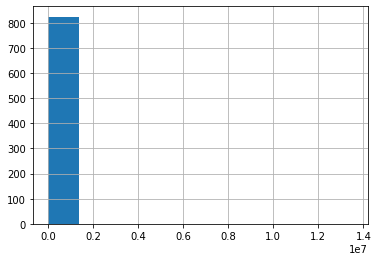

In [52]:
all_coordinates['Area'].hist()

In [53]:
all_coordinates.to_csv('all_coordinates.csv')
results6.to_csv('results6.csv')
results12.to_csv('results12.csv')
results18.to_csv('results18.csv')